# MOwNiT Laboratorium 2
## Zadanie 1
Napisz w dowolnym języku zwyczajną (wolną) dyskretną transformatę Fouriera.

Podstawowy wzór na dyskretną transformatę Fouriera prezentuje się w następujący sposób:

$$X_k = \sum_{n=0}^{N-1}x_n \cdot e^{-i2\pi kn/N}$$

Można jednak przedstawić go w wygodniejszej postaci macierzowej:

$$
\vec{X} = M\vec{x},\;\;\textrm{gdzie}
$$

$$
\vec{x} =
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{N-1}
\end{bmatrix},     
\;\;\vec{X} =
\begin{bmatrix}
X_0 \\
X_1 \\
\vdots \\
X_{N-1}
\end{bmatrix},
\;\;M = 
\begin{bmatrix}
e^{-i2\pi kn/N}
\end{bmatrix}_{k\times n}
$$

In [1]:
import numpy as np

def dft(x):
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n/N)   
    return  np.dot(M, x)

Aby upewnić się, że funkcja działa poprawnie, można porównać jej wynik z transformatą liczoną przez numpy:

In [2]:
x = np.random.random(2048)
np.allclose(dft(x), np.fft.fft(x))

True

Algorytm działa poprawnie, ale jest niewydajny - złożoność O(N²), co dla dużych N daje niesatysfakcjonujący czas wykonania.

## Zadanie 2

Wykorzystaj implementację z zadania 1. do napisania szybkiej wersji transformaty (używając pomysłu z algorytmu Cooleya-Tukeya).

Algorytm Cooleya-Tukeya polega na wykorzystaniu metody divide and conquer do podzielenia problemu na mniejsze podproblemy i zredukowaniu obliczeń w każdym z nich o połowę (dzięki symetrii DFT). Warunkiem stopu w poniższej implementacji jest zmniejszenie wejściowego wektora na tyle, że użycie zwykłej wersji DFT jest korzystniejsze. W tym przypadku empirycznie wyznaczyłem, że dzieje się to dla N <= 16.

In [3]:
def fft(x):
    N = x.shape[0]
    if not np.log2(N).is_integer():
        raise ValueError('Length of x must be a power of two')
    if N <= 16:
        return dft(x)
    
    n = np.arange(N)
    even = fft(x[::2])
    odd = fft(x[1::2])
    exponent = np.exp(-2j * np.pi * n / N)
    return np.concatenate([even + exponent[:N//2] * odd, even + exponent[N//2:] * odd])

Aby upewnić się, że funkcja działa poprawnie, można porównać jej wynik z transformatą liczoną przez numpy:

In [4]:
np.allclose(fft(x), np.fft.fft(x))

True

Algorytm Cooleya-Tukeya pozwala zmniejszyć złożoność z O(N²) do O(NlogN). Porównanie czasów obu wersji:

In [5]:
%timeit dft(x)
%timeit fft(x)

249 ms ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.24 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Zadanie 3

Przetestuj implementację z zadania 2. do wykonania analizy szeregu czasowego:
    1. Znajdź dane przedstawiające jakiś szereg czasowy.
    2. Załaduj je do programu.
    3. Zobacz, czy wykonanie analizy Fouriera na tych danych ma sens -- być może trzeba pogrupować je w równe odstępy.
    4. Narysuj wykres częstotliwości i postaraj się opisać jaka jest główna składowa.

Szereg czasowy:
https://www.kaggle.com/robikscube/hourly-energy-consumption#AEP_hourly.csv

In [6]:
import pandas as pd

df = pd.read_csv('resources/AEP_hourly.csv')
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

Dataframe składa się z dwóch kolumn:
 - Daty danego pomiaru (object, czyli string w Pandas)
 - Konsumpcji energii w megawatach (float64)
 
Po załadowaniu i zbadaniu danych można zająć się ich analizą:

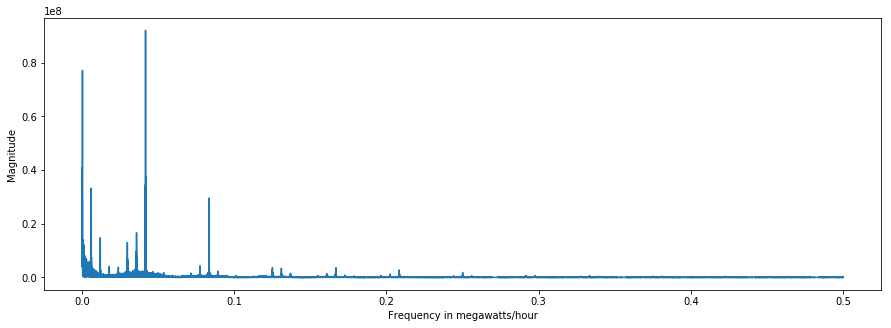

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

n = len(df)

X = fftpack.fft(df['AEP_MW'])
freqs = fftpack.fftfreq(len(df))

f, ax = plt.subplots()
f.set_size_inches(15, 5)
ax.plot(freqs[1:n//2], np.abs(X)[1:n//2])
ax.set_xlabel('Frequency in megawatts/hour')
ax.set_ylabel('Magnitude')
plt.show()

Dominującą częstotliwością jest 0.042 MW/h, czyli około 1 MW/dzień. Możemy więc przypuszczać, że w danych występują wzorce powtarzające się na co dzień.